**This notbeook is not done yet! Work in progress!**

## Problem Definition

To predict whether a passenger is going to survive or not.

In [55]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 5GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


## Explore the data.

Let's first read the training data.

In [56]:
df_train = pd.read_csv("/kaggle/input/titanic/train.csv")
df_train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [57]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [58]:
df_train.Pclass.value_counts()

3    491
1    216
2    184
Name: Pclass, dtype: int64

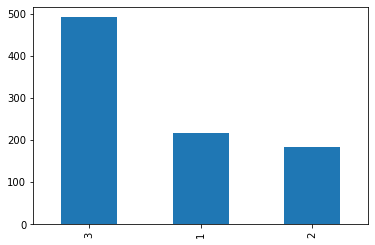

In [59]:
import matplotlib.pyplot as plt
df_train.Pclass.value_counts().sort_values(ascending=False).plot(kind='bar')
plt.show()

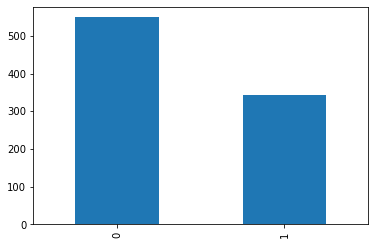

In [46]:
df_train.Survived.value_counts().sort_values(ascending=False).plot(kind='bar')
plt.show()

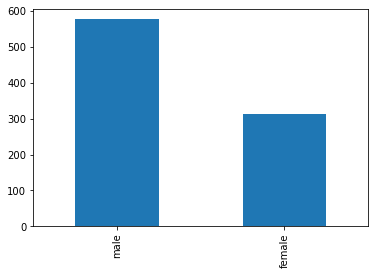

In [47]:
df_train.Sex.value_counts().sort_values(ascending=False).plot(kind='bar')
plt.show()

## Data imputation

In [48]:
df_train.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [49]:
df_train['Age'].fillna(df_train.Age.mean(), inplace=True)
df_train['Age'].isnull().sum()

0

In [50]:
# cabin by most frequent
df_train['Cabin'].fillna(df_train['Cabin'].value_counts().index[0], inplace=True)
df_train['Cabin'].isnull().sum()

0

In [54]:
df_train['Cabin'].value_counts()

145    691
47       4
63       4
141      3
62       3
      ... 
95       1
97       1
99       1
100      1
0        1
Name: Cabin, Length: 147, dtype: int64

In [51]:
## Changing "Sex" from categories to number

from sklearn.preprocessing import LabelEncoder

labelEncoder = LabelEncoder()
df_train['Sex'] = labelEncoder.fit_transform(df_train['Sex'])

In [52]:
df_train['Sex'].value_counts()

1    577
0    314
Name: Sex, dtype: int64

In [53]:
## changing cabin to numerical

df_train['Cabin'] = labelEncoder.fit_transform(df_train['Cabin'])
df_train['Cabin'].value_counts()

145    691
47       4
63       4
141      3
62       3
      ... 
95       1
97       1
99       1
100      1
0        1
Name: Cabin, Length: 147, dtype: int64

## Data imputation

1. We can fill in the mean value as age where we have null.
2. For cabin, we can put 0
3. For embarked, we can put most frequent.